In [1]:
import pathlib
import urllib
import sys
import pandas as pd
import numpy as np
from scipy.stats import trim_mean, iqr, skew, kurtosis
import sklearn.decomposition as deco
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Collect data

In [2]:
path = pathlib.Path('../data/adult.csv')
if path.exists():
    print('adult dataset found!')
else:
    sys.stdout.write('Downloading the adult dataset from the Internet...')
    ADULTURL = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    urllib.request.urlretrieve(ADULTURL, path.absolute())
    sys.stdout.write('Done!')

adult dataset found!


# 2. Understand the data in context


In [3]:
# Load the adult dataset into a Pandas dataframe
adult_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '>50K']
adult = pd.read_csv(path.absolute(),names=adult_columns)
for i in set(adult['education']):
    print(i)

 Some-college
 HS-grad
 Assoc-acdm
 7th-8th
 Bachelors
 Masters
 Prof-school
 10th
 5th-6th
 11th
 1st-4th
 9th
 Doctorate
 Preschool
 12th
 Assoc-voc


# 3. Understand the data
### 3.1 Describe the meansing and type for each attribute
 - **age**: numeric, continuous. 
 - **workclass**: categorical, discrete.
 - **fnlwgt**: numeric, continuous
 - **education**: ordinal, discrete
 - **education-num**: numeric, continuous
 - **marital-status**: categorical, discrete
 - **occupation**: categorical, discrete
 - **relationship**: categorical, discrete
 - **race**: categorical, discrete
 - **sex**: categorical, binary
 - **capital-gain**: numeric, continuous
 - **capital-loss**: numeric, continuous
 - **hours-per-week**: numeric, continuous
 - **native-country**: categorical, discrete
 - **>50k**: categorical, binary

*3.1 subsection: explanation for non-self-explanatory attributes*
 - **fnlwgt**: represents final weight. according to [2], it's the number of units that this record could represent in the 
 target population. In [1], the author explained that the final weight is controlled by three factors: a single cell estimatation
 of the population 16+ for each state; controls for Hispanic Origin by age and sex; controls by race, age and sex.
 - **education_num**: represents the number of years of education in total.[2]
 - **relationship**: represents the individual's role in it's family.[2]
 - **capital_gain** and **capital_loss**: represents the income and loss from non-salary ways, e.g. investment.[2]
 - **education**: due to lack of domain knowledge in U.S. education system, we decided to refer to [3].
 In which they order the education level in the following manner:  
 Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college < Bachelors < Masters < Doctorate.  
 [3] further merges  "Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th" and "12th" groups to "dropout" group,
 "Assoc-acdm" and "Assoc-voc" groups to "Associates" group,“HS-grad” and “Some-college” groups to “HS-Graduate” group.  
 For us, we would adopt this strategy, merging Prof-school into HS-Graduate group, and instead of arranging the education
 level like shown above, we have the following order:  
 dropout < hs-graduate < associates < bachelor < master < doctorate.
 
### 3.2 Verify data quality
#### 3.2.1 duplication

In [4]:
# Check duplication and drop duplication via pandas built in function
check_duplication = adult.duplicated()
duplicated = adult[check_duplication]
print("There are "+str(len(duplicated.index))+" duplicated data entries found.(One copy of the data entry will be kept in the dataset)")
adult = adult.drop_duplicates()
print("After drop duplicate, there are "+str(len(adult.index))+ " data entries remains.")
adult = adult.reset_index(drop=True)

There are 24 duplicated data entries found.(One copy of the data entry will be kept in the dataset)
After drop duplicate, there are 32537 data entries remains.


#### 3.2.2 missing values

In [5]:
# drop the indexes for which column has value '?'
unknown_row =[]

for i in range(len(adult.index)):
    if ('?' in adult.iloc[i]['workclass']) or ('?' in adult.iloc[i]['occupation']) or ('?' in adult.iloc[i]['native-country']):
        unknown_row.append(i)
adult = adult.drop(index = unknown_row)
adult = adult.reset_index(drop=True)

In [21]:
print(set(adult['education']))
# print(adult.loc[adult['education']==' Preschool'])
# print(set(adult['education']))

{' 10th', ' 7th-8th', ' Prof-school', ' 9th', ' 5th-6th', ' HS-grad', ' Some-college', ' Assoc-acdm', ' Bachelors', ' 12th', ' 1st-4th', ' Doctorate', ' Assoc-voc', ' 11th', ' Preschool', ' Masters'}


#### 3.2.3 finding outliers

To find outlier, we only focus on numeric values
As we can see in the following, the calculated lower bound and upper bound for both capital_gain and capital loss is both
0. In 3.3 section we will see that the median for these two value are 0 either. Which means in this dataset most of the people
doesn't do investment and thus investment does not incur gain or loss to their income. So for this two attribute we just
don't do anything to the outliers

In [6]:
# we calculate interquantile range add use it as our guide line as detecting outlier

adult_numrics = adult.select_dtypes(include=['int64'])
Q1 = adult_numrics.quantile(0.25)
Q3 = adult_numrics.quantile(0.75)
iqr = Q3-Q1
# print(iqr)
# print(adult_numrics['capital-gain'])
lower_bound = Q1 - 1.5 * iqr
upper_bound = Q3 + 1.5 * iqr
print("By calculating interquantile range, we can get the expected lower/upper bound for each numeric value")
adult_numrics = adult_numrics.drop(['capital-gain','capital-loss'],axis='columns')
lower_bound.drop(['capital-gain','capital-loss'],inplace=True)
upper_bound.drop(['capital-gain','capital-loss'],inplace=True)
print("As explained before we drop the catipal-gain and capital-loss condition, and thus we have")
outliers = adult_numrics[((adult_numrics<lower_bound) | (adult_numrics>upper_bound)).any(axis=1)]
print("lower bound as:")
print(lower_bound)
print("and upper bound as:")
print(upper_bound)
print("After reviewing this calculated lower and upper bound, we decided to change some of the value. Since the result")
print("value would be an outlier according to the interquantile range, but still a reasonable value in reality")
print("The lower bound of hours-per-week is set to 20, which is the expected value for a part-time job")
print("The upper bound of age is set to 85, which is longer than the life expectancy in U.S., and around the value of ")
print("life expectancy in Canada")
print("The upper bound of hours-per-week is set to 72, which is calculated according to the \'famous\' 9-9-6 working load")
print("in China.")
print("The upper bound of education-num is set to 26, which is a little bit longer than the expected year of education of")
print("a Ph.D., which is 6 years for elementary, 6 years for middle and high school, 4 year undergraduate, 2 year master")
print("and 5 year Ph.D. studentship, add up to 23 years.")

lower_bound['hours-per-week'] = 20
upper_bound['age']=85
upper_bound['hours-per-week']=72
upper_bound['education-num'] = 26
outliers = adult_numrics[((adult_numrics<lower_bound) | (adult_numrics>upper_bound)).any(axis=1)]
print("After applying such filter, we found %d outliers in the dataset, which is a pretty large portion of the dataset"%len(outliers.index))
adult_inliers = adult.drop(outliers.index)
print("Consider the number of the outliers is quite big, we will just keep them inside the dataset and have a closer")
print("look in section 4 Exceptional Work")

By calculating interquantile range, we can get the expected lower/upper bound for each numeric value
As explained before we drop the catipal-gain and capital-loss condition, and thus we have
lower bound as:
age                  -0.5
fnlwgt           -62338.0
education-num         3.0
hours-per-week       32.5
dtype: float64
and upper bound as:
age                   75.5
fnlwgt            417570.0
education-num         19.0
hours-per-week        52.5
dtype: float64
After reviewing this calculated lower and upper bound, we decided to change some of the value. Since the result
value would be an outlier according to the interquantile range, but still a reasonable value in reality
The lower bound of hours-per-week is set to 20, which is the expected value for a part-time job
The upper bound of age is set to 85, which is longer than the life expectancy in U.S., and around the value of 
life expectancy in Canada
The upper bound of hours-per-week is set to 72, which is calculated according to 

In [7]:
"""
Numericalize the categorical columns
"""
# mapping dictioniary for education row, we take education as a ordinal attribute, as was explained earlier
education_mapping_dict = {' Preschool':1, ' 1st-4th':1, ' 5th-6th':1, ' 7th-8th':1, ' 9th':1, ' 10th':1, ' 11th':1, ' 12th':1,
                          ' HS-grad':2, ' Prof-school':2, ' Some-college':2,
                          ' Assoc-voc':3, ' Assoc-acdm':3,
                          ' Bachelors':4,
                          ' Masters':5,
                          ' Doctorate':6}
categorical_list=['workclass','marital-status','occupation','relationship','race','sex','native-country']
def categorical_is_converted(input_dtype):
    """
    check if the target categorical value is converted to some integer value
    :param input_dtype: the datatype of the input column
    :return: True if the dtype is some kind of integer, False otherwise
    """
    return input_dtype in [np.int, np.int64, np.int32, np.long]
def one_hot_batch(df, attribute_list,prefix_list=None):
    """
    :param attribute_list: list of attributes that waiting to be one hotted 
    :param prefix_list: list of prefix for the attribute after one-hot representation, if not set, just use the attribute name
    :return: False if unexpected input found, otherwise return the result dataframe
    """
    if prefix_list is None:
        prefix_list = attribute_list
    if not len(attribute_list) == len(prefix_list):
        return False
    for i in range(len(attribute_list)):
        if not categorical_is_converted(df[attribute_list[i]].dtype):
            dummies = pd.get_dummies(df[attribute_list[i]], prefix=prefix_list[i])
            df = df.drop(columns=[attribute_list[i]])
            df = pd.concat([df,dummies], axis=1)
    return df
# map education to integers
if not categorical_is_converted(adult['education'].dtype):
    adult = adult.replace({'education': education_mapping_dict})
# convert all non-ordinal categorical attribute using one-hot representation
adult = one_hot_batch(adult, categorical_list)
# map the prediction target: the ultimate income rank into integer. Since it's binary, we don't use one hot representation
if not categorical_is_converted(adult['>50K'].dtype):
    for i in range(len(adult.index)):
        if '>50K' in adult.iloc[i]['>50K']:
            adult.iloc[i, adult.columns.get_loc('>50K')] = 1
        else:
            adult.iloc[i,adult.columns.get_loc('>50K')] = 0
adult.sample(5)

,age,fnlwgt,education,education-num,capital-gain,capital-loss,hours-per-week,>50K,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
26510,57,201991,4,13,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13975,36,184498,1,7,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13431,23,256211,2,10,0,0,24,0,0,0,...,0,0,0,0,0,0,0,0,1,0
11427,37,249392,3,11,0,0,40,1,0,1,...,0,0,0,0,0,0,0,1,0,0
20716,49,240869,1,4,0,0,35,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
adult.head(5)

,age,fnlwgt,education,education-num,capital-gain,capital-loss,hours-per-week,>50K,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,4,13,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,4,13,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,2,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,1,7,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,4,13,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1. Statistics about Numeric values

In [25]:
# select all columns with numeric values
adult_numeric = adult.select_dtypes(include=np.number)

In [26]:
adult_numeric.head(5)

,age,fnlwgt,education,education-num,capital-gain,capital-loss,hours-per-week,>50K,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,4,13,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,4,13,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,2,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,1,7,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,4,13,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
cnames = ['mean', 'median', 'mode', 'trimmed mean (p=20%)', 'min', 'max', 'range', 'std']
adult_numeric.agg(lambda x: pd.Series([np.mean(x), np.median(x),x.mode()[0], trim_mean(x, 0.2),x.min(),x.max(),x.max()-x.min(),x.std()], index=cnames))

,age,fnlwgt,education,education-num,capital-gain,capital-loss,hours-per-week,>50K,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
mean,38.441720,1.897950e+05,2.499054,10.122532,1092.841202,88.439928,40.934703,0.249046,0.031288,0.068582,...,0.001128,0.003617,0.000365,0.002356,0.001394,0.000564,0.000597,0.912008,0.002123,0.000531
median,37.000000,1.784170e+05,2.000000,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
mode,36.000000,2.034880e+05,2.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
trimmed mean (p=20%),37.364999,1.775251e+05,2.240365,10.025104,0.000000,0.000000,40.860879,0.081780,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
min,17.000000,1.376900e+04,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,1.484705e+06,6.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
range,73.000000,1.470936e+06,5.000000,15.000000,99999.000000,4356.000000,98.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,13.131426,1.056586e+05,1.142607,2.548738,7409.110596,404.445239,11.978753,0.432468,0.174099,0.252747,...,0.033569,0.060030,0.019101,0.048480,0.037305,0.023743,0.024431,0.283288,0.046033,0.023035


### 2. Statistics about Categorical values

In [28]:
# select all columns with categorical values
adult_categorical = adult.select_dtypes(include=['object'])

In [29]:
adult_categorical.head(5)

""
0
1
2
3
4


In [30]:
cnames = adult_categorical.columns.tolist()
cnames

[]

In [31]:
adult_categorical['workclass'].value_counts()

KeyError: 'workclass'

In [ ]:
adult_categorical['education'].value_counts()

In [ ]:
adult['marital-status'].value_counts()

In [ ]:
adult_categorical['occupation'].value_counts()

In [ ]:
adult['relationship'].value_counts()

In [ ]:
adult['race'].value_counts()

In [ ]:
adult['sex'].value_counts()

In [ ]:
adult['native-country'].value_counts()

In [ ]:
adult.groupby('workclass').agg(['mean', lambda x: trim_mean(x, 0.2), 'median', 'std']).T

In [ ]:
adult.cov()

# 4 Exceptional work
In section 3.2.3 we used interquantile range to find the outlier, and we found around 4000 samples are tagged as outlier,
which is quite a large portion. So, in this section, we will study these outliers and evaluate how they influence our viewport
of this dataset. Our evaluation of outlier finding algorithm includes the following two aspects:

 - We employ some dimensional reduction algorithm that reduces the entire dataset to 2 and 3 dimension, we then treat 
 outliers and commoners as different classes and render them in different colors, and thus study their behavior.
 - We employ classifiers trained on both full training set and the training set without outlier, and we observed a accuracy
 loss using 5-fold validation, we thus conclude that the out-lier detection with interquantile range does not fit this dataset 
 
### 4.1 PCA and visualization
We applied principle component analysis to transform the entire dataset into 2d and 3d dimension, then we plot them with
scatter in both dimension. The outliers are in red color and the commoners are in blue color. In the 2d plot we can see 
that the outliers are basically overlaps with the commoners, and for the 3d plot we found out that the commoners and outliers
can be distinguishable; however, the distance between the outliers and the nearest commoners are not huge, and far less then
the furthest distance between different cluster of commoners, we therefore infer that the outliers are still valuable data
entries in our dataset and does not recommand to just remove this; we also infer that the outliers are introduced just 
because the nature of the data is not evenly distributed instead of an error. 

True
[[-1.12278991e+05  1.08464409e+03 -9.07193328e+01]
 [ 2.58509450e+04 -1.09345043e+03 -8.94071730e+01]
 [ 4.49259448e+04 -1.09401424e+03 -8.86662167e+01]
 ...
 [ 3.24920945e+05 -1.10232396e+03 -7.82713806e+01]
 [ 1.85294516e+03 -1.09274335e+03 -9.03658360e+01]
 [-7.36570548e+04 -1.09050291e+03 -9.31762692e+01]]


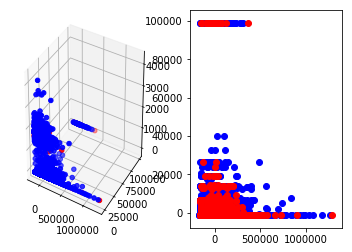

In [8]:
iqr_outliers = adult_numrics[((adult_numrics<lower_bound) | (adult_numrics>upper_bound)).any(axis=1)]
iqr_outliers.sample(5)
iqr_inliers = adult.drop(outliers.index)
iqr_outliers = adult.loc[iqr_outliers.index]
iqr_outliers.sample(5)
iqr_outliers.loc[:,'out_lier'] = 1
iqr_inliers.loc[:,'out_lier'] = 0
total = pd.concat([iqr_inliers,iqr_outliers])


print('out_lier' in iqr_outliers.columns)
is_outlier = total['out_lier']
pca = deco.PCA(n_components=3)
attributes = total.drop(columns=['out_lier']).values
reduced = pca.fit_transform(attributes)
print(reduced)
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

x0=[];y0=[];z0=[];x1=[];y1=[];z1=[]
for i in range(len(reduced)):
    if is_outlier[i] == 0:
        x0.append(reduced[i][0])
        y0.append(reduced[i][1])
        z0.append(reduced[i][2])
    else:
        x1.append(reduced[i][0])
        y1.append(reduced[i][1])
        z1.append(reduced[i][2])
ax.scatter(x0,y0,z0,c='b')
ax.scatter(x1,y1,z1,c='r')

pca2 = deco.PCA(n_components=2)
reduced = pca2.fit_transform(attributes)
bx = fig.add_subplot(122)
x0=[];y0=[];x1=[];y1=[]
for i in range(len(reduced)):
    if is_outlier[i] == 0:
        x0.append(reduced[i][0])
        y0.append(reduced[i][1])
    else:
        x1.append(reduced[i][0])
        y1.append(reduced[i][1])
bx.scatter(x0,y0,c='b')
bx.scatter(x1,y1,c='r')
plt.show()

### 4.2 Evaluation of outlier detection algorithm using performance of classifer

The intuition of collecting this dataset is to predict if a input person bolongs to high income group or not (>50K). So 
we employed two classification algorithm, trained and tested them using 5 fold validation. Both of the algorithm are trained
on both the full training data and the training data without outliers, and thus by comparing their performance we can evaluate
how outliers influences the classification process, and further evaluate the outlier detection algorithm.  
The two algorithm include Support Vector Machine (LinearSVC) which in theory should be easily influenced by outliers and 
Random Forest (RandomForestClassfier) which has some natural immunity to outliers.

After a 5 fold validation, we found out that for each classification algorithm, excluding outliers detected by IQR will 
introduce a minior loss in prediction accuracy, thus we conclude that detection outliers with interquantile range is not 
a feasible solution to this dataset. 

In [16]:
iqr_outliers
iqr_inliers
shuffeled_out=iqr_outliers.sample(frac=1)
out_lier_list=np.array_split(shuffeled_out,5)
shuffeled_in=iqr_inliers.sample(frac=1)
in_lier_list=np.array_split(shuffeled_in,5)

def get_acc(classifier_name, train_x, train_y, test_x, test_y):
    """
    calculate the accuracy trained with the given training data and return the accuracy evaluated using the given testing
    data
    :param classifier_name: a string indicating the target classifier algorithm, should be either 'SVM' or 'RF' 
    :param train_x: attributes of the training set
    :param train_y: label of the training set
    :param test_x: attributes of the testing set
    :param test_y: label of the testing set
    :return: the accuracy evaluated on the testing set
    """
    if classifier_name == 'SVM':
        classifier_ = LinearSVC(max_iter=5000)
    else:
        classifier_ = RandomForestClassifier(n_estimators=50, max_depth=5)
    classifier_.fit(train_x, train_y)
    return classifier_.score(test_x, test_y)
svm_all = []
svm_inlier = []
rf_all = []
rf_inlier = []
for i in range(5):
    test = [out_lier_list[i],in_lier_list[i]]
    test_ = pd.concat(test)
    train = out_lier_list[0:i]+out_lier_list[i+1:5]+in_lier_list[0:i]+in_lier_list[i+1:5]
    train_ = pd.concat(train)
    train_inliers = train_.loc[train_['out_lier']==0]
    svm_all.append(get_acc('SVM',
                           train_x=train_.drop(columns=['out_lier','>50K']),
                           train_y=train_['>50K'],
                           test_x=test_.drop(columns=['out_lier','>50K']),
                           test_y=test_['>50K']
                           )
                   )
    svm_inlier.append(get_acc('SVM',
                           train_x=train_inliers.drop(columns=['out_lier','>50K']),
                           train_y=train_inliers['>50K'],
                           test_x=test_.drop(columns=['out_lier','>50K']),
                           test_y=test_['>50K']
                           )
                   )
    rf_all.append(get_acc('RF',
                           train_x=train_.drop(columns=['out_lier','>50K']),
                           train_y=train_['>50K'],
                           test_x=test_.drop(columns=['out_lier','>50K']),
                           test_y=test_['>50K']
                           )
                   )
    rf_inlier.append(get_acc('RF',
                           train_x=train_inliers.drop(columns=['out_lier','>50K']),
                           train_y=train_inliers['>50K'],
                           test_x=test_.drop(columns=['out_lier','>50K']),
                           test_y=test_['>50K']
                           )
                   )

C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Us

In [19]:
def mean(lst):
    return sum(lst)/float(len(lst))
print("svm with all training data average accuracy "+ str(mean(svm_all)))
print("svm with commoner training data average accuracy "+ str(mean(svm_inlier)))
print("RandomForest with all training data average accuracy "+ str(mean(rf_all)))
print("RandomForest with commoner training data average accuracy "+ str(mean(rf_inlier)))

[0.7783676177836761, 0.7858327803583278, 0.7798606502986065, 0.7838420703384207, 0.7617388418782147]
[0.7826808228268082, 0.42070338420703385, 0.787657597876576, 0.7777040477770405, 0.7559316409490625]
[0.8385865958858659, 0.8349369608493696, 0.8342733908427339, 0.8307896483078965, 0.8378961340633815]
[0.8364299933642999, 0.8379230258792303, 0.8375912408759124, 0.8299601857996018, 0.8330844532935126]
svm with all training data average accuracy 0.7779283921314493
svm with commoner training data average accuracy 0.7049354987273042
RandomForest with all training data average accuracy 0.8352965459898496
RandomForest with commoner training data average accuracy 0.8349977798425113


# Reference
    [1] Kaggle adult census income dataset. Date accessed: Sept. 2019. url: https://www.kaggle.com/uciml/adult-census-income
    [2] Haojun Zhu, Predicting Earning Potential using the Adult Dataset. Dec. 2016. url: https://rstudio-pubs-static.s3.amazonaws.com/235617_51e06fa6c43b47d1b6daca2523b2f9e4.html
    [3] Bui Dinh Chien, Jean-Daniel Zucker, Complex Data Mining Project. Date accessed: Sept. 2019. url: https://sites.google.com/site/complexdataminingproject/.